# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка библиотек и данных

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error

from scipy import stats as st

random = 12345

import warnings
warnings.filterwarnings('ignore')

import time

In [75]:
auto = pd.read_csv('/datasets/autos.csv')

###  Осмотр данных

In [76]:
display(auto.head(5))
display(auto.info())
display(auto.describe())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Обработка данных

#### Колонка Price

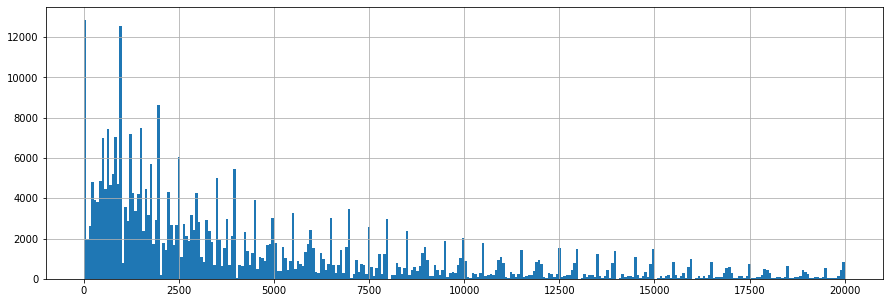

In [77]:
auto['Price'].hist(bins=300, figsize=(15,5))

Видим большое количество значений возле нуля, рассмотри более детально

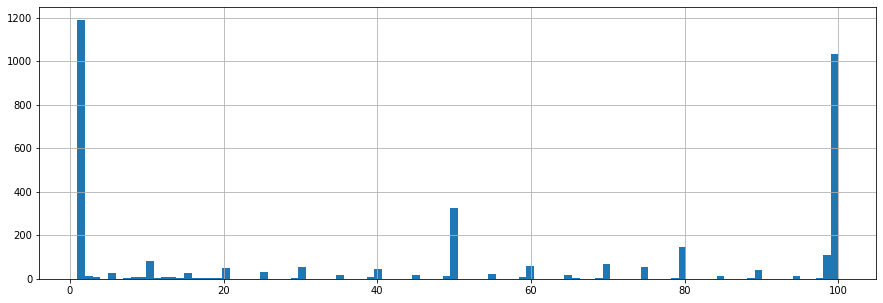

In [78]:
auto['Price'].hist(bins=100, figsize=(15,5), range=[1, 100])

Посмотрим сами объявления с ценой меньше 100 евро

In [79]:
auto[auto['Price'] < 100]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32
354309,2016-03-09 22:37:41,99,small,1999,manual,60,arosa,150000,1,petrol,seat,yes,2016-03-09 00:00:00,0,91301,2016-04-06 22:15:32


Большое количество строк с нулевой ценой и подозрительно низкой ценой, это скорее всего не рыночные варианты:
- Сломанные;
- Старые;
- Не расстаможенные
и тп

А так как мы рассматриваем модель для рыночных вариантов то эти данные удаляем, тем более что их всего около 4%.

In [80]:
auto = auto[auto['Price'] > 100]

#### Колонка VehicleType

In [81]:
display(auto['VehicleType'].value_counts())
print('Количество пропущенных значений:', auto['VehicleType'].isna().sum())

sedan          88965
small          77029
wagon          63384
bus            28256
convertible    19807
coupe          15534
suv            11758
other           3040
Name: VehicleType, dtype: int64

Количество пропущенных значений: 32251


Заменяем NaN на 'nondef' чтобы наша модель учитывала когда в объявлении нет данных по признаку

In [82]:
auto['VehicleType'].fillna('nondef', inplace=True)

In [83]:
print('Количество пропущенных значений:', auto['VehicleType'].isna().sum())

Количество пропущенных значений: 0


#### Колонка RegistrationYear

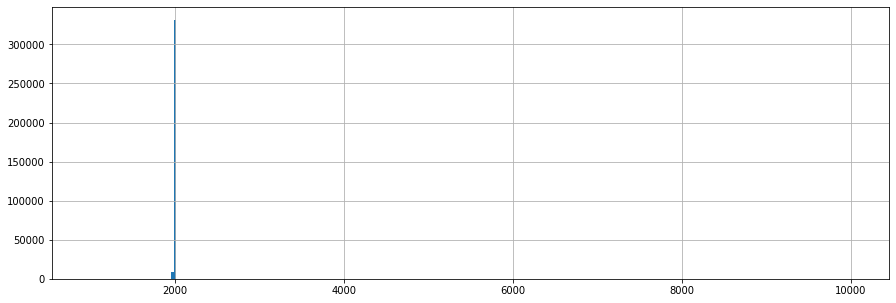

In [84]:
auto['RegistrationYear'].hist(bins=300, figsize=(15,5))

Взглянем на подозрительные года регистрации авто более 2022 года и ниже 1950 года

In [85]:
auto.query('RegistrationYear < 1950 or RegistrationYear > 2022')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25 00:00:00,0,58135,2016-03-25 15:58:21
2273,2016-03-15 21:44:32,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no,2016-03-15 00:00:00,0,79288,2016-04-07 05:15:34
6977,2016-03-24 08:37:22,135,nondef,1910,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-24 00:00:00,0,19374,2016-04-06 20:46:08
10183,2016-03-27 13:59:08,1250,nondef,1910,NaN,0,other,5000,0,NaN,audi,NaN,2016-03-27 00:00:00,0,18445,2016-04-07 10:45:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340759,2016-04-04 23:55:47,700,nondef,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04 00:00:00,0,86343,2016-04-05 06:44:07
346046,2016-03-26 16:45:28,18900,suv,1943,manual,60,other,150000,3,petrol,volkswagen,no,2016-03-26 00:00:00,0,51065,2016-03-26 16:45:28
351682,2016-03-12 00:57:39,11500,nondef,1800,NaN,16,other,5000,6,petrol,fiat,NaN,2016-03-11 00:00:00,0,16515,2016-04-05 19:47:27
353531,2016-03-16 21:56:55,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,NaN,2016-03-16 00:00:00,0,23936,2016-03-30 18:47:41


Значений не много, на модель не повлияет поэтому удаляем их

In [86]:
auto = auto.query('RegistrationYear >= 1950 and RegistrationYear <= 2022')

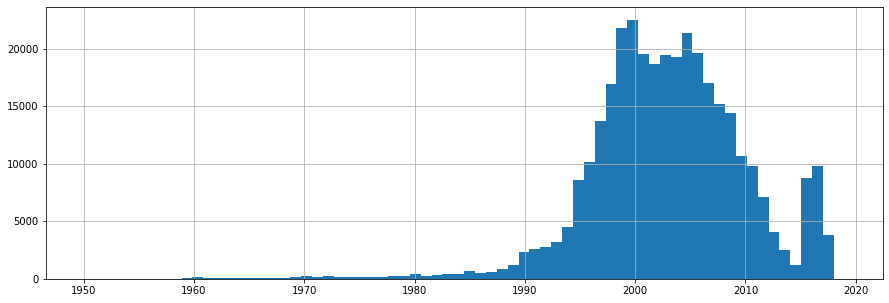

In [87]:
auto['RegistrationYear'].hist(bins=70, figsize=(15,5))

In [88]:
auto['RegistrationYear'].describe()

count    339811.000000
mean       2003.246466
std           7.184909
min        1950.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

In [89]:
print("Вывод года сбора данных:", pd.to_datetime(auto['DateCrawled']).dt.year.unique())
auto['year'] = pd.to_datetime(auto['DateCrawled']).dt.year

Вывод года сбора данных: [2016]


In [90]:
auto = auto[auto['RegistrationYear'] < 2017]

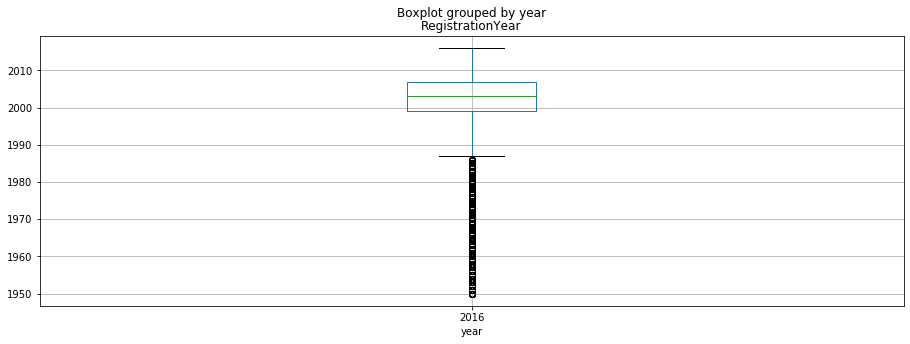

In [91]:
auto.boxplot(by ='year', column = ['RegistrationYear'], figsize=(15,5))

In [92]:
Q1 = auto['RegistrationYear'].quantile(0.25)
Q3 = auto['RegistrationYear'].quantile(0.75)
IQR = Q3 - Q1

auto = auto[(auto['RegistrationYear'] > Q1-1.5*IQR )]

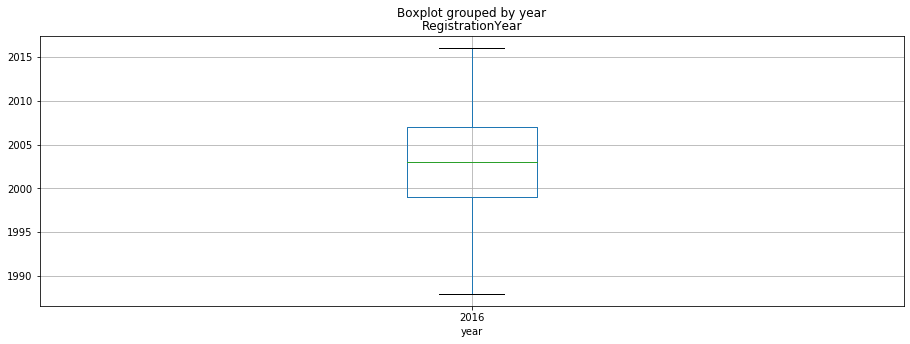

In [93]:
auto.boxplot(by ='year', column = ['RegistrationYear'], figsize=(15,5))

#### Колонка Gearbox

In [94]:
auto['Gearbox'].value_counts()

manual    244857
auto       61419
Name: Gearbox, dtype: int64

In [95]:
print('Количество пропущенных значений:', auto['Gearbox'].isna().sum())

Количество пропущенных значений: 13480


Заменяем NaN на 'nondef' чтобы наша модель учитывала когда в объявлении нет данных по признаку

In [96]:
auto['Gearbox'].fillna('nondef', inplace=True)

In [97]:
print('Количество пропущенных значений:', auto['Gearbox'].isna().sum())

Количество пропущенных значений: 0


# Колонка Power

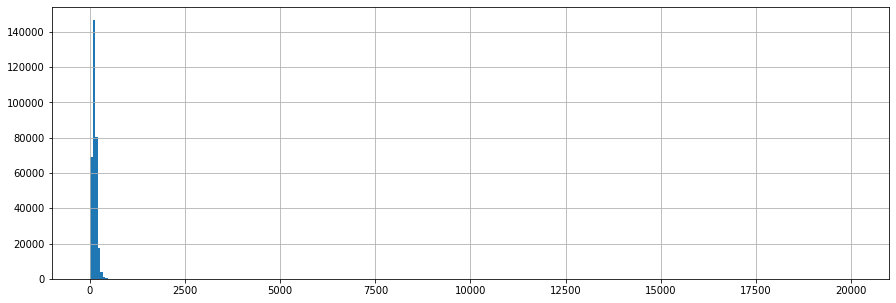

In [98]:
auto['Power'].hist(bins=300, figsize=(15,5))

Для того что бы определить какие значения отсекать посмотрим до 1000 лс

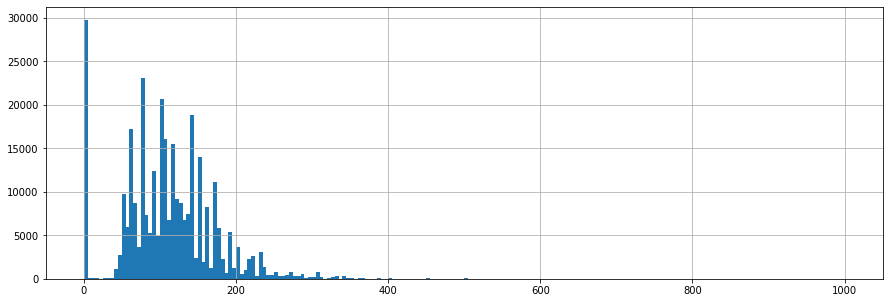

In [99]:
auto['Power'].hist(bins=200, figsize=(15,5), range=[0, 1000])

Посмотрим на объявления до 20 л.с

In [100]:
auto.query('Power <= 20').head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,year
0,2016-03-24 11:52:17,480,nondef,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016
32,2016-03-15 20:59:01,245,sedan,1994,nondef,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43,2016
37,2016-03-28 17:50:15,1500,nondef,2016,nondef,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02,2016
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32,2016
55,2016-03-26 10:39:35,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26 00:00:00,0,56759,2016-04-01 23:17:27,2016
69,2016-04-01 11:56:40,1200,coupe,2001,nondef,0,astra,150000,0,NaN,opel,NaN,2016-04-01 00:00:00,0,47249,2016-04-07 08:46:07,2016
70,2016-03-08 01:36:42,800,small,1993,manual,0,polo,150000,3,petrol,volkswagen,no,2016-03-08 00:00:00,0,8258,2016-04-05 23:46:00,2016
90,2016-03-23 11:53:21,2400,sedan,2003,manual,0,a4,150000,9,gasoline,audi,NaN,2016-03-23 00:00:00,0,40210,2016-03-23 11:53:21,2016
94,2016-03-28 16:37:43,8390,nondef,2009,nondef,0,insignia,150000,0,NaN,opel,NaN,2016-03-28 00:00:00,0,29221,2016-03-30 07:44:59,2016
98,2016-03-11 19:00:25,4290,bus,2008,manual,0,combo,150000,2,gasoline,opel,no,2016-03-11 00:00:00,0,23568,2016-04-05 22:45:32,2016


Видим что тут в основном нули, посмотрим сколько их

In [101]:
print('Количество объявлений с автомобилями менее 20 л.с.:', (auto['Power'] <= 20).sum())

Количество объявлений с автомобилями менее 20 л.с.: 29986


Видно что таких объявлений значительное количество, но не критическое удалим их, но будем иметь ввиду что если наша модель будет плохо обрабатывать значения близкие к нулю то необходимо будет доработать данные в этой части

In [102]:
auto = auto[auto['Power'] >= 20]

Посмотрим на данные более 500 л.с.

In [103]:
display(auto.query('Power > 500')['Power'].describe())
display(auto.query('Power > 500').head())
print('Количество объявлений с автомобилями более 500 л.с.:', (auto['Power'] >= 500).sum())

count      375.000000
mean      3020.341333
std       4165.503293
min        504.000000
25%        750.500000
50%       1390.000000
75%       2012.500000
max      20000.000000
Name: Power, dtype: float64

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,year
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,0,22043,2016-03-22 21:43:26,2016
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03 00:00:00,0,60326,2016-04-07 14:56:46,2016
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,2016-03-29 00:00:00,0,33154,2016-04-06 05:44:36,2016
6296,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31 00:00:00,0,44379,2016-04-01 03:41:52,2016
6504,2016-03-14 15:54:34,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,NaN,2016-03-14 00:00:00,0,40721,2016-03-14 15:54:34,2016


Количество объявлений с автомобилями более 500 л.с.: 408


Види что это в большинстве своем подозрительные объявления о обычных автомобилях, с ошибкой в поле мощности.<br>
Отсекаем объявления с мощностью более 500 лс.<br>

(0, 1000)

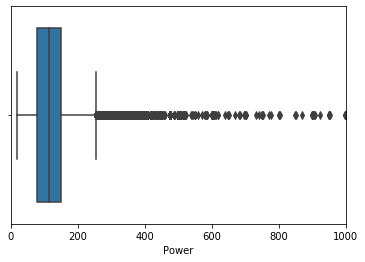

In [104]:
sns.boxplot(auto['Power'])
plt.xlim(0, 1000)

In [105]:
Q1 = auto['Power'].quantile(0.25)
Q3 = auto['Power'].quantile(0.75)
IQR = Q3 - Q1

auto = auto[(auto['Power'] < Q3 + 1.5 * IQR )]
print(Q3 + 1.5 * IQR)

255.0


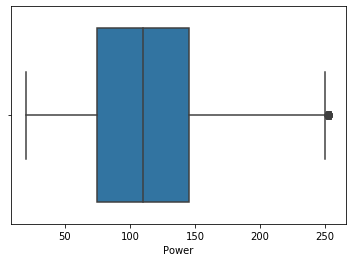

In [106]:
sns.boxplot(auto['Power'])

#### Колонка Model

In [107]:
auto['Model'].value_counts()

golf          24046
other         17338
3er           16853
polo          10502
corsa          9944
              ...  
i3                5
samara            5
6er               3
911               3
rangerover        2
Name: Model, Length: 246, dtype: int64

In [108]:
auto[auto['Model'].isna()].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,year
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03 00:00:00,0,45665,2016-04-05 11:47:13,2016
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31,2016
151,2016-03-27 20:47:22,6799,small,2009,nondef,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27 00:00:00,0,89077,2016-03-27 20:47:22,2016
161,2016-03-28 10:50:04,1495,wagon,2001,nondef,64,NaN,150000,9,gasoline,volkswagen,NaN,2016-03-28 00:00:00,0,99086,2016-04-04 11:45:46,2016


Заменяем NaN на 'nondef' чтобы наша модель учитывала когда в объявлении нет данных по признаку

In [109]:
auto['Model'].fillna('nondef', inplace=True)

In [110]:
print('Количество пропущенных значений:', auto['Model'].isna().sum())

Количество пропущенных значений: 0


#### Колонка Kilometer

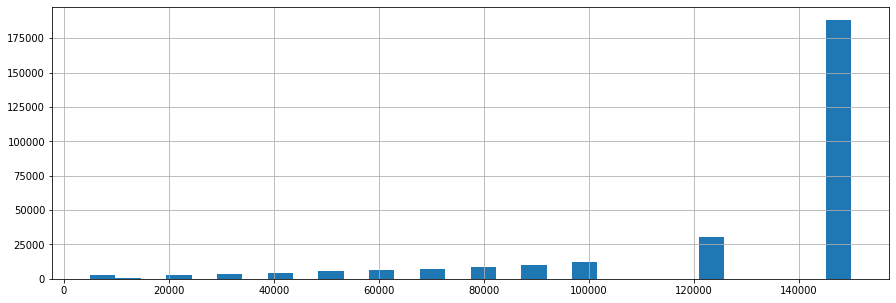

In [111]:
auto['Kilometer'].hist(bins=30, figsize=(15,5))

In [112]:
print('Количество пропущенных значений:', auto['Kilometer'].isna().sum())

Количество пропущенных значений: 0


#### Колонка RegistrationMonth

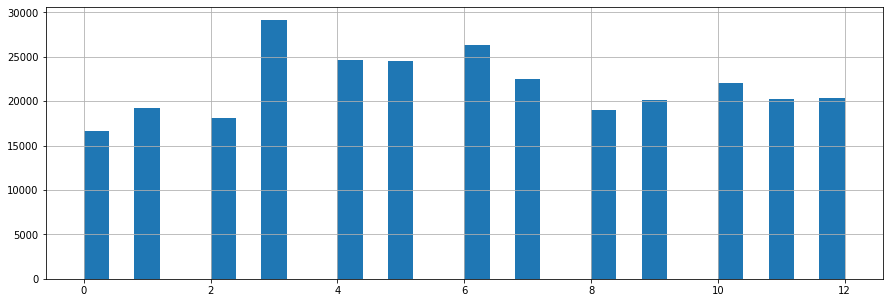

In [113]:
auto['RegistrationMonth'].hist(bins=30, figsize=(15,5))

In [114]:
print('Количество пропущенных значений:', auto['RegistrationMonth'].isna().sum())

Количество пропущенных значений: 0


#### Колонка FuelType

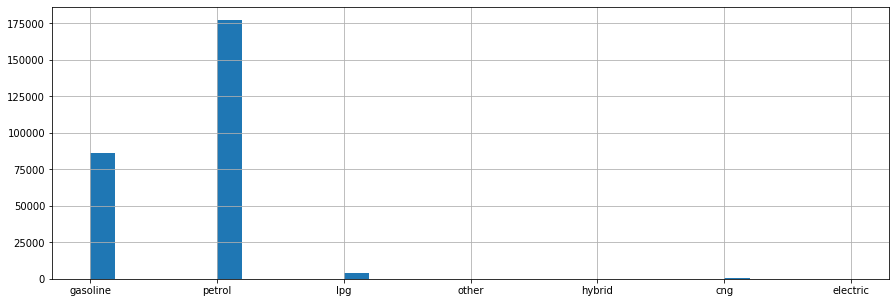

In [115]:
auto['FuelType'].hist(bins=30, figsize=(15,5))

In [116]:
print('Количество пропущенных значений:', auto['FuelType'].isna().sum())

Количество пропущенных значений: 14590


In [117]:
auto['FuelType'].fillna('nondef', inplace=True)

In [118]:
print('Количество пропущенных значений:', auto['FuelType'].isna().sum())

Количество пропущенных значений: 0


#### Колонка Brand

In [119]:
auto['Brand'].value_counts()

volkswagen        62149
opel              31692
bmw               30069
mercedes_benz     24728
audi              24062
ford              20112
renault           13706
peugeot            9337
fiat               7404
seat               5755
skoda              4912
mazda              4611
smart              4477
citroen            4132
toyota             3969
nissan             3887
hyundai            3089
mini               2950
volvo              2702
mitsubishi         2442
honda              2337
kia                2081
suzuki             1914
alfa_romeo         1877
chevrolet          1270
chrysler           1101
sonstige_autos      955
dacia               799
daihatsu            601
subaru              586
jeep                527
saab                447
land_rover          403
daewoo              402
lancia              356
rover               355
jaguar              303
porsche             272
lada                137
trabant             122
Name: Brand, dtype: int64

In [120]:
print('Количество пропущенных значений:', auto['Brand'].isna().sum())

Количество пропущенных значений: 0


#### Колонка NotRepaired

In [121]:
auto['NotRepaired'].value_counts()

no     215286
yes     27250
Name: NotRepaired, dtype: int64

In [122]:
print('Количество пропущенных значений:', auto['NotRepaired'].isna().sum())

Количество пропущенных значений: 40494


In [123]:
auto['NotRepaired'].fillna('nondef', inplace=True)

In [124]:
print('Количество пропущенных значений:', auto['NotRepaired'].isna().sum())

Количество пропущенных значений: 0


#### Колонка DateCreated

In [125]:
auto['DateCreated'].value_counts()

2016-04-03 00:00:00    11167
2016-04-04 00:00:00    10723
2016-03-12 00:00:00    10450
2016-03-20 00:00:00    10390
2016-03-21 00:00:00    10064
                       ...  
2015-11-02 00:00:00        1
2016-01-18 00:00:00        1
2016-01-19 00:00:00        1
2016-01-16 00:00:00        1
2016-01-20 00:00:00        1
Name: DateCreated, Length: 105, dtype: int64

In [126]:
print('Количество пропущенных значений:', auto['DateCreated'].isna().sum())

Количество пропущенных значений: 0


#### Колонка NumberOfPictures

In [127]:
auto['NumberOfPictures'].value_counts()

0    283030
Name: NumberOfPictures, dtype: int64

In [128]:
print('Количество пропущенных значений:', auto['NumberOfPictures'].isna().sum())

Количество пропущенных значений: 0


#### Колонка PostalCode

In [129]:
auto['PostalCode'].value_counts()

10115    722
65428    494
66333    270
52525    240
78224    238
        ... 
88719      1
82444      1
63931      1
31094      1
38879      1
Name: PostalCode, Length: 8105, dtype: int64

In [130]:
print('Количество пропущенных значений:', auto['PostalCode'].isna().sum())

Количество пропущенных значений: 0


#### Колонка LastSeen

In [131]:
auto['LastSeen'].value_counts()

2016-04-06 12:15:45    15
2016-04-06 12:44:51    15
2016-04-06 12:46:17    15
2016-04-07 09:44:27    15
2016-04-06 12:17:37    14
                       ..
2016-03-26 13:36:43     1
2016-03-15 10:44:45     1
2016-04-02 09:47:49     1
2016-03-13 02:17:59     1
2016-03-16 19:50:21     1
Name: LastSeen, Length: 149740, dtype: int64

In [132]:
print('Количество пропущенных значений:', auto['LastSeen'].isna().sum())

Количество пропущенных значений: 0


#### Вывод

- Удалены объявления с ценой менее 100 евро;
- В колоке VehicleType отсутствующие значения заменены на nondef;
- Удалены объявления с RegistrationYear меньше 1989 года и больше 2016 года;
- В колоке Gearbox отсутствующие значения заменены на nondef;
- Удалены объявления с мощностью до 20 л.с. и более 255 л.с.;
- В колоке Model отсутствующие значения заменены на nondef;
- В колоке FuelType отсутствующие значения заменены на nondef;
- В колоке NotRepaired отсутствующие значения заменены на nondef.

### Выбор данных как признаки

Колонки которые не помогут модели определения цены:
- DateCrawled 
- RegistrationMonth 
- NumberOfPictures 
- DateCreated 
- LastSeen

Колонки которые будем использовать как признаки:
- VehicleType 
- RegistrationYear 
- Gearbox 
- Power 
- Model 
- Kilometer 
- FuelType 
- Brand 
- NotRepaired 
- PostalCode

Целевая колонка:
- Price

In [133]:
features = auto[['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']]
target = auto['Price']

Здесь была попытка кодировать категоральные признаки через OHE, но стало настолько много колонок, что в дальнейшем это привело к запредельному времени обучения даже на простых моделях.

Кодирование категоральных признаков

In [136]:
cathegorial = ['VehicleType', 'Gearbox', 'Model',
               'FuelType', 'Brand', 'NotRepaired']
encoder = OrdinalEncoder()
features_cathegorial = pd.DataFrame(
    encoder.fit_transform(features[cathegorial]),
    index=features[cathegorial].index,
    columns=features[cathegorial].columns
)

non_coded = features[['RegistrationYear', 'Power', 'Kilometer', 'PostalCode']]
features = pd.concat([features_cathegorial, non_coded], axis=1)


features.head()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationYear,Power,Kilometer,PostalCode
1,2.0,1.0,161.0,2.0,1.0,2.0,2011,190,125000,66954
2,7.0,0.0,117.0,2.0,14.0,1.0,2004,163,125000,90480
3,6.0,1.0,116.0,7.0,38.0,0.0,2001,75,150000,91074
4,6.0,1.0,101.0,2.0,31.0,0.0,2008,69,90000,60437
5,5.0,1.0,11.0,7.0,2.0,2.0,1995,102,150000,33775


Разделение на тренировочную и тестовую выборки

In [137]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=random)

### Вывод

- Библиотеки и данные загружены;
- По результатам обработки данных:
    - Удалены объявления с ценой менее 100 евро;
    - В колоке VehicleType отсутствующие значения заменены на nondef;
    - Удалены объявления с RegistrationYear меньше 1950 года и больше 2022 года;
    - В колоке Gearbox отсутствующие значения заменены на nondef;
    - Удалены объявления с мощностью до 20 л.с. и более 500 л.с.;
    - В колоке Model отсутствующие значения заменены на nondef;
    - В колоке FuelType отсутствующие значения заменены на nondef;
    - В колоке NotRepaired отсутствующие значения заменены на nondef.
- Выбраны следующие колонки как признаки:
    - VehicleType;
    - RegistrationYear;
    - Gearbox;
    - Power;
    - Model;
    - Kilometer;
    - FuelType;
    - Brand;
    - NotRepaired;
    - PostalCode.
- Целевой признак
    - Price.
- Категоральные признаки преобразованы с помощью OrdinalEncoder.

## Обучение моделей

In [138]:
variable = ['RMSE', 'T_train', 'T_predict']
model = ['RandomForestRegressor', 'LGBMRegressor', 'XGBRegressor']
RMSE = []
training_time = []
prediction_time = []

In [139]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 80, num = 30)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [6, 10, 24],
               'min_samples_split': [2, 5],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

rf_RandomGrid = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=12345)
                                   , param_distributions = param_grid
                                   , cv = 5
                                   , verbose=2
                                   , n_jobs = 4
                                   , scoring="neg_mean_squared_error"
                                   , random_state = 12345)
  
rf_RandomGrid.fit(features_train, target_train)

print('-----------------------')
print('Лучшие параметры модели:')
print(rf_RandomGrid.best_estimator_)
print('')
print('"root_mean_squared_error:')
print(np.sqrt(-rf_RandomGrid.best_score_))
print('-----------------------')

best_rf_regressor = RandomForestRegressor(n_estimators = rf_RandomGrid.best_params_["n_estimators"],
                            max_features      = rf_RandomGrid.best_params_["max_features"],
                            max_depth         = rf_RandomGrid.best_params_["max_depth"],
                            min_samples_split = rf_RandomGrid.best_params_["min_samples_split"],
                            min_samples_leaf  = rf_RandomGrid.best_params_["min_samples_leaf"],
                            bootstrap         = rf_RandomGrid.best_params_["bootstrap"])

t0 = time.time()
best_rf_regressor.fit(features_train, target_train)
t1 = time.time()

t2 = time.time()
predictions = best_rf_regressor.predict(features_valid)
t3 = time.time()

#Так можно вывести результаты всех итераций
#cv_results = rf_RandomGrid.cv_results_
#for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
#    print(np.sqrt(-mean_score), params)

result = mean_squared_error(target_valid, predictions) ** 0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result)

print('Затраченное время на обучение модели:', t1-t0)
print('Затраченное время предсказания модели:', t3-t2)

RMSE.append(result)
training_time.append(t1-t0)
prediction_time.append(t3-t2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  4.2min finished


-----------------------
Лучшие параметры модели:
RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=24, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=41, n_jobs=None, oob_score=False,
                      random_state=12345, verbose=0, warm_start=False)

"root_mean_squared_error:
1421.654469187636
-----------------------
RMSE модели линейной регрессии на валидационной выборке: 1374.7285358416825
Затраченное время на обучение модели: 13.166781902313232
Затраченное время предсказания модели: 0.8252851963043213


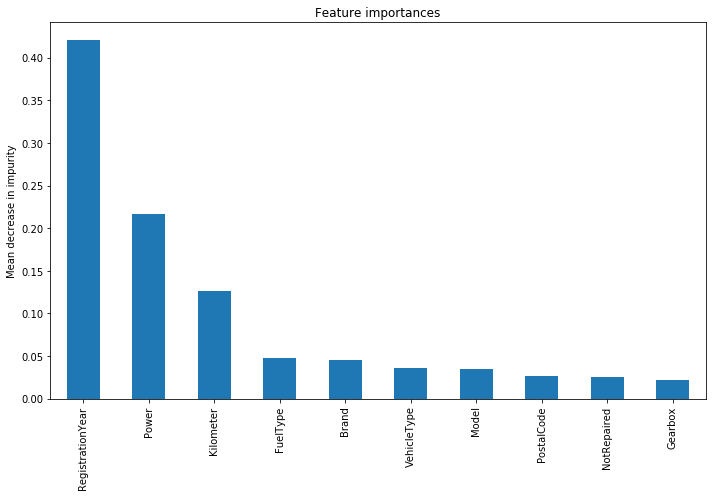

In [140]:
feature_names = features_train.columns 
importances = best_rf_regressor.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([best_rf_regressor.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [142]:
params = {
    'num_leaves': [7, 50],
    'learning_rate': [0.1, 0.003],
    'n_estimators': [1, 100],
}

lgbm_RandomGrid = RandomizedSearchCV(lgb.LGBMRegressor(random_state=12345), 
                                     params, 
                                     verbose=1, 
                                     scoring='neg_mean_squared_error',
                                     cv=5,
                                     random_state = 12345)

lgbm_RandomGrid.fit(features_train, target_train)


print('-----------------------')
print('Лучшие параметры модели:')
print(lgbm_RandomGrid.best_estimator_)
print('')
print('"root_mean_squared_error:')
print(np.sqrt(-lgbm_RandomGrid.best_score_))
print('-----------------------')

best_lgbm_regressor = lgb.LGBMRegressor(learning_rate = lgbm_RandomGrid.best_params_["learning_rate"],
                           n_estimators  = lgbm_RandomGrid.best_params_["n_estimators"],
                           num_leaves     = lgbm_RandomGrid.best_params_["num_leaves"],
                           eval_metric='rmse')

t0 = time.time()
best_lgbm_regressor.fit(features_train, target_train)
t1 = time.time()

t2 = time.time()
predictions = best_lgbm_regressor.predict(features_valid)
t3 = time.time()

result = mean_squared_error(target_valid, predictions) ** 0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result)

print('Затраченное время на обучение модели:', t1-t0)
print('Затраченное время на предсказание модели:', t3-t2)

RMSE.append(result)
training_time.append(t1-t0)
prediction_time.append(t3-t2)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   36.3s finished


-----------------------
Лучшие параметры модели:
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=50, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

"root_mean_squared_error:
1512.2973374618512
-----------------------
RMSE модели линейной регрессии на валидационной выборке: 1487.7203302377177
Затраченное время на обучение модели: 1.7266008853912354
Затраченное время на предсказание модели: 0.667546272277832


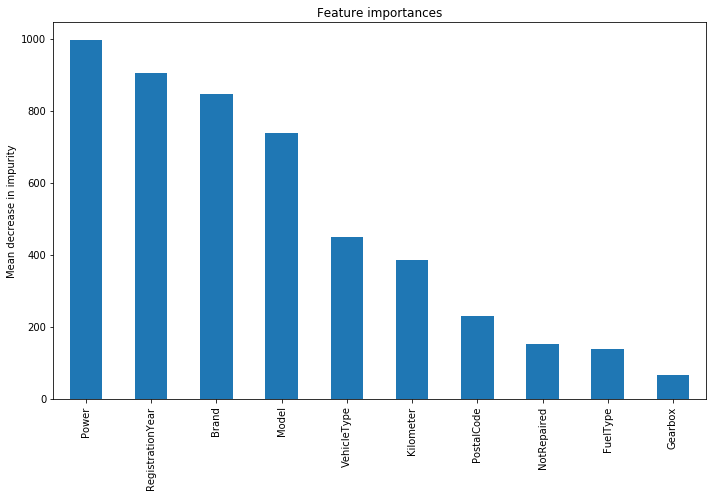

In [143]:
feature_names = features_train.columns 
importances = best_lgbm_regressor.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([best_lgbm_regressor.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [144]:
param_grid = {"max_depth":    [10, 30],
              "learning_rate": [0.01, 0.015]}


XGBR_RandomGrid = RandomizedSearchCV(xgb.XGBRegressor(eval_metric='rmse', n_estimators = 150, random_state = 12345),
                                     param_grid,
                                     cv=5,
                                     random_state=12345)

XGBR_RandomGrid.fit(features_train, target_train)

print('-----------------------')
print('Лучшие параметры модели:')
print(lgbm_RandomGrid.best_estimator_)
print('')
print('"root_mean_squared_error:')
print(np.sqrt(-lgbm_RandomGrid.best_score_))
print('-----------------------')

best_xgbr_regressor = xgb.XGBRegressor(learning_rate = XGBR_RandomGrid.best_params_["learning_rate"],
                           n_estimators  = 150,
                           max_depth     = XGBR_RandomGrid.best_params_["max_depth"],
                           eval_metric='rmse')

t0 = time.time()
best_xgbr_regressor.fit(features_train, target_train)
t1 = time.time()

t2 = time.time()
predictions = best_xgbr_regressor.predict(features_valid)
t3 = time.time()

result = np.sqrt(mean_squared_error(target_valid, predictions))
print("RMSE модели линейной регрессии на валидационной выборке:", result)

print('Затраченное время на обучение модели:', t1-t0)
print('Затраченное время на предсказание модели:', t3-t2)

RMSE.append(result)
training_time.append(t1-t0)
prediction_time.append(t3-t2)

[00:05:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:09:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:16:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

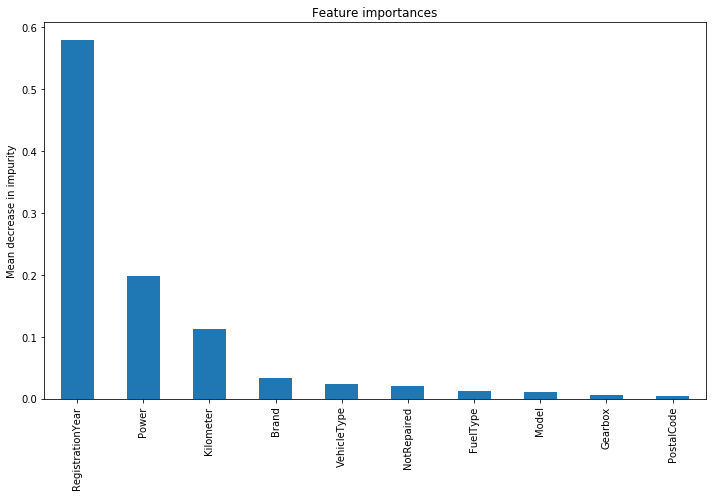

In [145]:
feature_names = features_train.columns 
importances = best_xgbr_regressor.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([best_lgbm_regressor.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Анализ моделей

**Модель RandomForestRegressor:**<br>
С помощью модели RandomForestRegressor получили лучший результат на тренировочной выборке RMSE - 1421 на валидационной выборке RMSE - 1375 на следующих параметрах:
- n_estimators - 41;
- min_samples_split - 2;
- min_samples_leaf - 2;
- max_features - sqrt;
- max_depth - 24;
- bootstrap - False.

Затраченное время:
- На обучение модели: 13 с;
- На предсказание: 0.8 с.

**Модель LightGBM:**<br>
С помощью модели lightgbm получили лучший результат на тренировочной выборке RMSE - 1512 на валидационной выборке RMSE - 1488 на следующих параметрах:
- objective - rmse;
- learning_rate - 0.1;
- num_leaves - 50;
- subsample - 1.0.

Затраченное время:
- На нахождение лучшей модели: 2 с;
- На предсказание: 0.7 с.

**Модель XGBRegressor:**<br>
С помощью модели XGBRegressor получили лучший результат на тренировочной выборке RMSE - 1071 на валидационной выборке RMSE - 1773 на следующих параметрах:
- max_depth - (-1);
- learning_rate - 0.1;
- n_estimators - 150.

Затраченное время:
- На нахождение лучшей модели: 249 с;
- На предсказание: 13 с.

In [146]:
res_df = pd.DataFrame(np.column_stack([RMSE, training_time, prediction_time]), 
                               columns=variable, index=model)
display(res_df)

,RMSE,T_train,T_predict
RandomForestRegressor,1374.728536,13.166782,0.825285
LGBMRegressor,1487.720330,1.726601,0.667546
XGBRegressor,1612.529556,248.835855,12.643050


**Выбор модели останавливаем на RandomForestRegressor, так как она показала лучший параметр RMSE и приемлимую скорость обучения и предсказания.**

## Вывод

**Подготовка данных:**
- Библиотеки и данные загружены;
- По результатам обработки данных:
    - Удалены объявления с ценой менее 100 евро;
    - В колоке VehicleType отсутствующие значения заменены на nondef;
    - Удалены объявления с RegistrationYear меньше 1989 года и больше 2017 года;
    - В колоке Gearbox отсутствующие значения заменены на nondef;
    - Удалены объявления с мощностью до 20 л.с. и более 255 л.с.;
    - В колоке Model отсутствующие значения заменены на nondef;
    - В колоке FuelType отсутствующие значения заменены на nondef;
    - В колоке NotRepaired отсутствующие значения заменены на nondef.
- Выбраны следующие колонки как признаки:
    - VehicleType;
    - RegistrationYear;
    - Gearbox;
    - Power;
    - Model;
    - Kilometer;
    - FuelType;
    - Brand;
    - NotRepaired;
    - PostalCode.
- Целевой признак
    - Price.
- Категоральные признаки преобразованы с помощью OrdinalEncoder.

**Обучены модели RandomForestRegressor, LightGBM, XGBRegressor и проведен их анализ**<br>
**Модель RandomForestRegressor:**<br>
С помощью модели RandomForestRegressor получили лучший результат на тренировочной выборке RMSE - 1421 на валидационной выборке RMSE - 1375 на следующих параметрах:
- n_estimators - 41;
- min_samples_split - 2;
- min_samples_leaf - 2;
- max_features - sqrt;
- max_depth - 24;
- bootstrap - False.

Затраченное время:
- На обучение модели: 13 с;
- На предсказание: 0.8 с.

**Модель LightGBM:**<br>
С помощью модели lightgbm получили лучший результат на тренировочной выборке RMSE - 1512 на валидационной выборке RMSE - 1488 на следующих параметрах:
- objective - rmse;
- learning_rate - 0.1;
- num_leaves - 50;
- subsample - 1.0.

Затраченное время:
- На нахождение лучшей модели: 2 с;
- На предсказание: 0.7 с.

**Модель XGBRegressor:**<br>
С помощью модели XGBRegressor получили лучший результат на тренировочной выборке RMSE - 1071 на валидационной выборке RMSE - 1773 на следующих параметрах:
- max_depth - (-1);
- learning_rate - 0.1;
- n_estimators - 150.

Затраченное время:
- На нахождение лучшей модели: 249 с;
- На предсказание: 13 с.

**Выбор модели останавливаем на RandomForestRegressor, так как она показала лучший параметр RMSE и приемлимую скорость обучения и предсказания.**